In [12]:
#pip install kneed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sea
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer

In [3]:
df = pd.read_csv('Mall_Customers.csv')

In [4]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']

#income is generally skew which is bad for KNN, well log transform to reduce skew
#df['Annual Income (k$)'] = np.log(df['Annual Income (k$)'])


features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()


,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980


In [6]:
features

array([[-1.73899919, -1.42456879, -0.43480148],
       [-1.73899919, -1.28103541,  1.19570407],
       [-1.70082976, -1.3528021 , -1.71591298],
       [-1.70082976, -1.13750203,  1.04041783],
       [-1.66266033, -0.56336851, -0.39597992],
       [-1.66266033, -1.20926872,  1.00159627],
       [-1.62449091, -0.27630176, -1.71591298],
       [-1.62449091, -1.13750203,  1.70038436],
       [-1.58632148,  1.80493225, -1.83237767],
       [-1.58632148, -0.6351352 ,  0.84631002],
       [-1.58632148,  2.02023231, -1.4053405 ],
       [-1.58632148, -0.27630176,  1.89449216],
       [-1.54815205,  1.37433211, -1.36651894],
       [-1.54815205, -1.06573534,  1.04041783],
       [-1.54815205, -0.13276838, -1.44416206],
       [-1.54815205, -1.20926872,  1.11806095],
       [-1.50998262, -0.27630176, -0.59008772],
       [-1.50998262, -1.3528021 ,  0.61338066],
       [-1.43364376,  0.94373197, -0.82301709],
       [-1.43364376, -0.27630176,  1.8556706 ],
       [-1.39547433, -0.27630176, -0.590

In [7]:
gender = df['Gender']
newdf = scaled_features.join(gender)

newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

newdf = newdf.drop(['Gender_Male'],axis=1)

newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1


C:\Users\mdelan02\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Inertia')

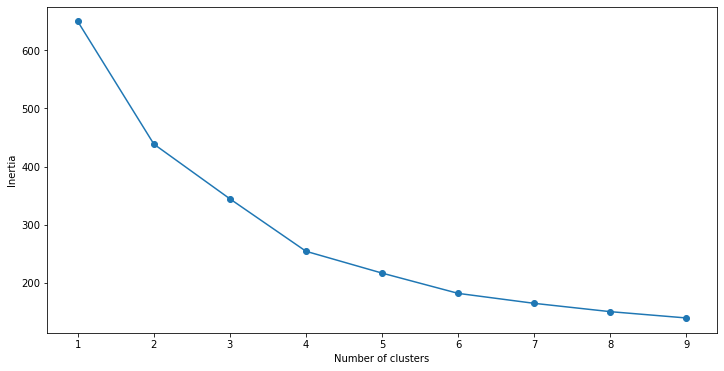

In [8]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
#plotting to find the elbow of the figure which is the optimal # of clusters

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [9]:
#function to find knees if visual is difficult
kneecheck = KneeLocator(frame['Cluster'],frame['SSE'],curve ='convex',direction='decreasing')

kneecheck.knee

4

In [10]:
#Finding the silhouette score
newdf = newdf.drop(['label'], axis=1, errors='ignore')
kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(newdf)

#print the silhouette score of this model (-1 to 1, 1 being highest)

print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.35027020434653977


In [11]:
#get labels
newdf = newdf.drop(['label'], axis=1, errors='ignore')
clusters = kmeans.fit_predict(newdf.iloc[:,0:])
newdf["label"] = clusters

In [12]:
set(newdf['label'])

{0, 1, 2, 3}

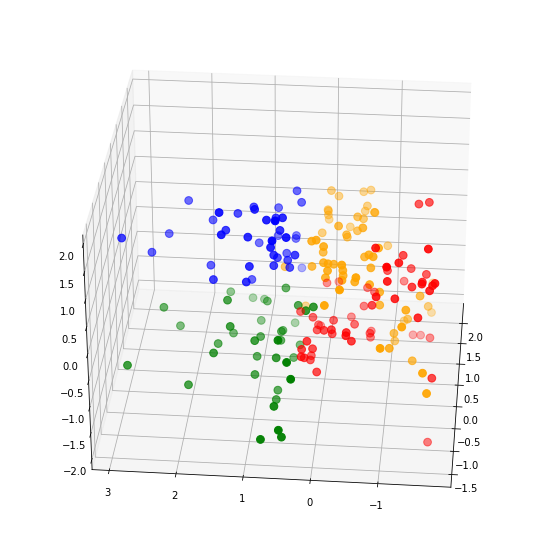

In [13]:
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)

ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)
ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

In [14]:
newdf.head()

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female,label
0,-1.738999,-1.424569,-0.434801,0,1
1,-1.738999,-1.281035,1.195704,0,1
2,-1.700830,-1.352802,-1.715913,1,1
3,-1.700830,-1.137502,1.040418,1,1
4,-1.662660,-0.563369,-0.395980,1,1


In [18]:
newdf.iloc[:,:-1]

,Annual Income (k$),Age,Spending Score (1-100),Gender_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1
...,...,...,...,...
195,2.268791,-0.276302,1.118061,1
196,2.497807,0.441365,-0.861839,1
197,2.497807,-0.491602,0.923953,0
198,2.917671,-0.491602,-1.250054,0


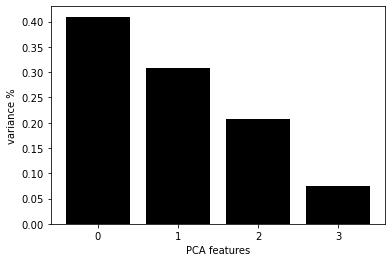

In [49]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf.iloc[:,:-1])

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

C:\Users\mdelan02\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


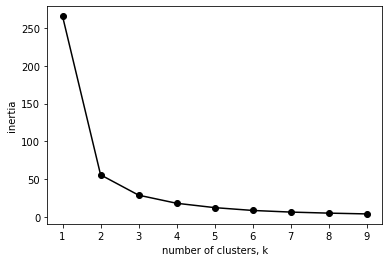

In [50]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:1])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [51]:
kneecheck = KneeLocator(frame['Cluster'],inertias,curve ='convex',direction='decreasing')

kneecheck.knee

2

In [52]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:1])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:1], model.labels_, metric='euclidean')) 

0.5591168613892543


In [53]:
#mapping clusters back to the dataset

df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

pred = model.predict(PCA_components.iloc[:,:1])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,3
1,Male,21,15,81,0
2,Female,20,16,6,2
3,Female,23,16,77,0
4,Female,31,17,40,3


In [54]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,27.833333,62.750000,79.116667
1,1,55.829787,58.638298,26.404255
2,2,42.767857,62.053571,37.035714
3,3,29.216216,57.189189,53.459459


<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

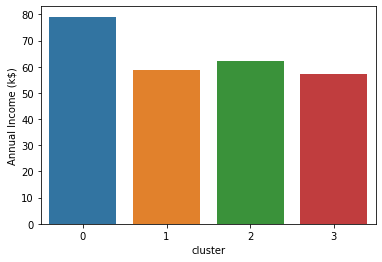

In [55]:
sns.barplot(x='cluster',y='Age',data=avg_df)
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df)
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df)

In [56]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2.head()

Gender
cluster Gender        
0       Female      35
        Male        25
1       Female      22
        Male        25
2       Female      33

In [ ]:
'''
KNN is a descriptive measure. For us to use this for persona's we take graphs of the variables in we see in the custers
then describe them. Why are we stopping the math and letting humans take over? This also seems like it would fail on clusters
with higher dimensionality.

Can we determine what features make a cluster important mathematically and use that to describe it?
'''

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

In [134]:
numClusters = len(set(frame['cluster']))

In [151]:
clusterList = []
for i in range(numClusters):
    df = frame.copy()
    df['orig_cluster'] = df['cluster']
    clusterList.append(df)

In [152]:
for n,j in enumerate(clusterList):
    j.loc[j['cluster'] != n, 'cluster'] = numClusters
    j.loc[j['cluster'] == n, 'cluster'] = 1
    j.loc[j['cluster'] == numClusters, 'cluster'] = 0